In [3]:
%matplotlib inline

In [70]:
import astropy.units as u
from astropy.convolution import Gaussian1DKernel

from spectral_cube import SpectralCube
from radio_beam import Beam

from regions import Regions


In [5]:
from pathlib import Path

sd_data_path = Path("/Users/ekoch/storage/LGLBS/feathering_tests/")
vla_data_path = Path("/Users/ekoch/storage/LGLBS/C+D_HI_2023/")


In [6]:
from uvcombine.scale_factor import find_scale_factor

from cube_analysis.feather_cubes import feather_compare_cube

In [74]:
from cube_analysis.feather_cubes import feather_compare_cube

from cube_analysis.reprojection import reproject_cube

from sklearn.mixture import GaussianMixture

from uvcombine.scale_factor import find_scale_factor


# Test on WLM:

In [72]:
vla_cube = SpectralCube.read(vla_data_path / "wlm_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_hdu = fits.open(sd_data_path / "WLM_GBT.FITS")[0]
# gbt_hdu.header['TIMESYS'] = 'utc'

gbt_cube = SpectralCube.read(gbt_hdu)

print(gbt_hdu.header['TIMESYS'])
# print(gbt_cube.header['TIMESYS'])

utc


In [44]:
gbt_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SFL'  'DEC--SFL'  'VOPT-F2W'  
CRVAL : 0.491666674614  0.0  -249286.0  
CRPIX : 64.0  595.0856934  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.02916666679  0.02916666679  5143.95459  
NAXIS : 0  0

In [30]:
# Make a cut out to avoid the noisy edges in the GBT map

gbt_region = Regions.read(sd_data_path / "wlm_gbt_cutout.reg")
print(gbt_region)
gbt_cube = gbt_cube.subcube_from_regions(gbt_region)  

[<RectangleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (0.48514404, -15.44499637)>, width=7008.7108 arcsec, height=6889.2452 arcsec, angle=0.0 deg)>]


In [31]:
vla_cube

SpectralCube with shape=(51, 1600, 1536) and unit=Jy / beam:
 n_x:   1536  type_x: RA---SIN  unit_x: deg    range:     1.374061 deg:  359.611754 deg
 n_y:   1600  type_y: DEC--SIN  unit_y: deg    range:   -16.348091 deg:  -14.571364 deg
 n_s:     51  type_s: VRAD      unit_s: m / s  range:  -228144.203 m / s:  -21967.973 m / s

In [32]:
gbt_cube

SpectralCube with shape=(63, 66, 67) and unit=Jy / beam:
 n_x:     67  type_x: RA---SFL  unit_x: deg    range:     1.485826 deg:  359.497508 deg
 n_y:     66  type_y: DEC--SFL  unit_y: deg    range:   -16.394166 deg:  -14.498333 deg
 n_s:     63  type_s: VOPT-F2W  unit_s: m / s  range:  -249286.000 m / s:   69979.108 m / s

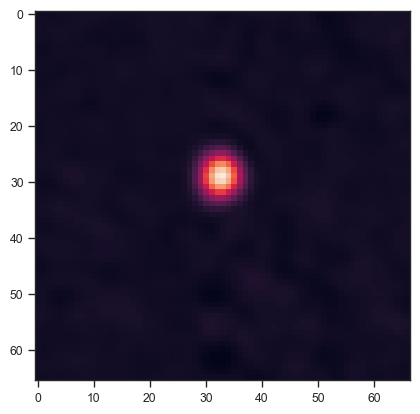

In [33]:
gbt_cube[30].quicklook()

In [34]:
gbt_cube.beam.major.to(u.arcmin)

<Quantity 8.703 arcmin>

In [35]:
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')

gbt_cube

SpectralCube with shape=(63, 66, 67) and unit=Jy / beam:
 n_x:     67  type_x: RA---SFL  unit_x: deg    range:     1.485826 deg:  359.497508 deg
 n_y:     66  type_y: DEC--SFL  unit_y: deg    range:   -16.394166 deg:  -14.498333 deg
 n_s:     63  type_s: VRAD-F2F  unit_s: km / s  range:     -249.493 km / s:      69.963 km / s

In [36]:
gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

gbt_cube_specinterp

SpectralCube with shape=(51, 66, 67) and unit=Jy / beam:
 n_x:     67  type_x: RA---SFL  unit_x: deg    range:     1.485826 deg:  359.497508 deg
 n_y:     66  type_y: DEC--SFL  unit_y: deg    range:   -16.394166 deg:  -14.498333 deg
 n_s:     51  type_s: VRAD-F2F  unit_s: km / s  range:     -228.144 km / s:     -21.968 km / s

In [232]:
# gbt_reproj = gbt_cube_specinterp.reproject(vla_cube.header)

# gbt_reproj

gbt_reproj_0 = gbt_cube_specinterp[-1].reproject(vla_cube[-1].header)

vla_flux = []
gbt_flux = []

# for chan in range(gbt_cube_specinterp.shape[0]):
#     print(chan)
#     vla_flux.append(np.nansum(vla_cube[chan]).value)
#     gbt_reproj_chan = gbt_cube_specinterp[chan].reproject(vla_cube[chan].header)
#     gbt_reproj_chan = gbt_reproj_chan * np.isfinite(vla_cube[chan])
#     gbt_flux.append(np.nansum(gbt_reproj_chan.value))


In [53]:
beam_ratio = gbt_cube_specinterp.beam.sr / vla_cube.beam.sr
print(beam_ratio)

588.1524240532295


In [233]:
# plt.plot(gbt_cube_specinterp.spectral_axis.value, vla_flux, label='VLA')
# plt.plot(gbt_cube_specinterp.spectral_axis.value, gbt_flux / beam_ratio, label='GBT')

# plt.legend()

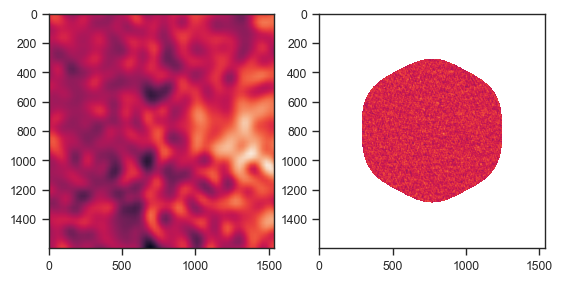

In [48]:
plt.subplot(121)
plt.imshow(gbt_reproj_0.value)

plt.subplot(122)
plt.imshow(vla_cube[-1].value)

In [61]:
from cube_analysis.reprojection import reproject_cube

(sd_data_path / "wlm_gbt_matched_to_C+D_hilores.fits").unlink()

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               "wlm_gbt_matched_to_C+D_hilores.fits",
               output_folder=sd_data_path,
               reproject_type='spatial')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/wlm_gbt_matched_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [68]:
gbt_reproj = SpectralCube.read(sd_data_path / "wlm_gbt_matched_to_C+D_hilores.fits")
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

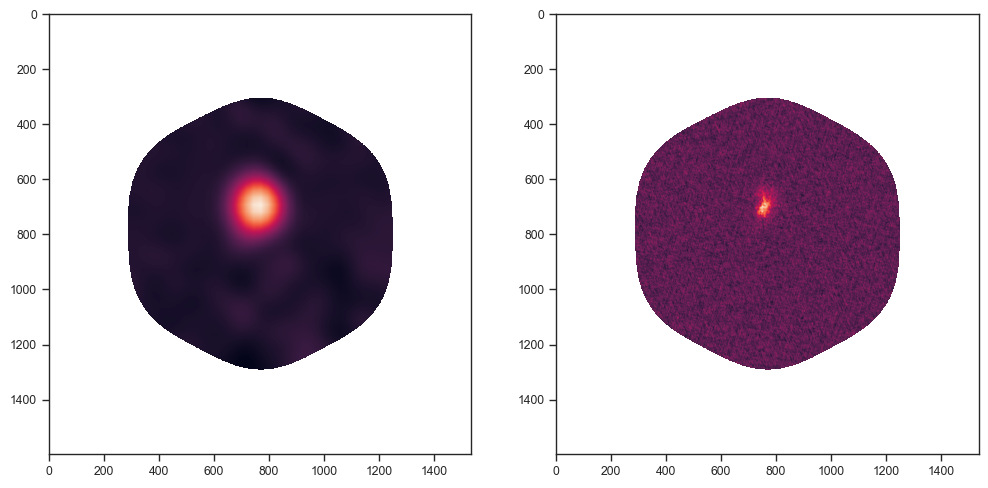

In [209]:
plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.imshow(gbt_reproj[15].value)

plt.subplot(122)
plt.imshow(vla_cube[15].value)

In [172]:
gbt_reproj_madstd = gbt_reproj.to(u.K).mad_std(axis=(1, 2))
vla_madstd = vla_cube.to(u.K).mad_std(axis=(1, 2))


In [208]:
# plt.subplot(121)
# plt.plot(gbt_reproj_madstd.value, label='GBT')
# plt.plot(vla_madstd.value, label='VLA')

# plt.ylabel("rms (K)")
# plt.legend()

# plt.subplot(122)
# plt.plot(vla_madstd.value / gbt_reproj_madstd.value, label='VLA / GBT')

# plt.ylabel("Ratio of rms")

In [163]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())
# las = (hi_freq.to(u.cm, u.spectral()) / (50 * u.m)).to(u.arcsec, u.dimensionless_angles())
print(las)
# print(argh)

# radii, ratios, high_pts, low_pts, chan_out = \
#             feather_compare_cube(vla_cube, gbt_reproj, las,
#                                  num_cores=1,
#                                  chunk=250,
#                                  verbose=True,
#                                  # weights=weight,
#                                  relax_spectral_check=False,
#                                  spec_check_kwargs={'rtol': 0.01})

radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=9.1*u.arcmin,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})


1088.3621328572976 arcsec
INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


Optimization terminated successfully.
         Current function value: 1.613541
         Iterations: 38
         Function evaluations: 74
0.83\pm0.01


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


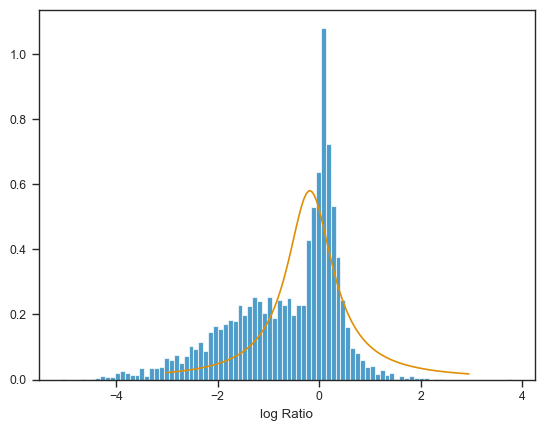

In [164]:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts), np.hstack(high_pts),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}\pm{sc_err:.2f}")

Text(0.5, 0.01, 'log Ratio')

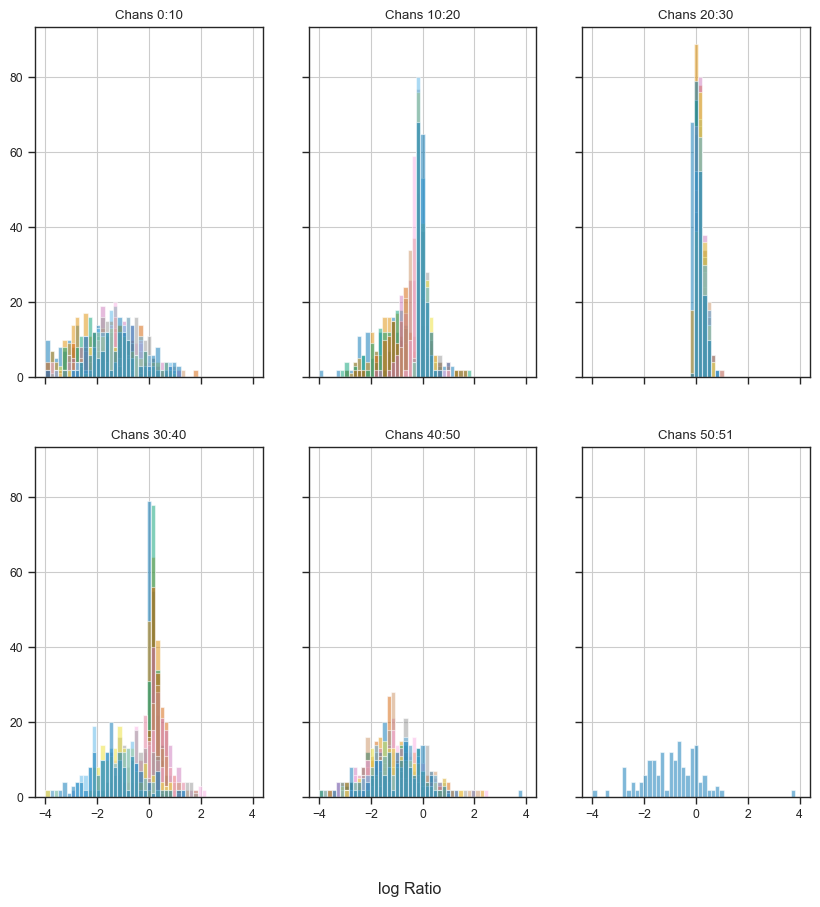

In [210]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 10))

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            _ = ax.hist(np.log(ratios[chan]), bins=bins, alpha=0.5)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supxlabel(f"log Ratio")

Text(0.5, 0.01, 'Angular Scale (arcsec)')

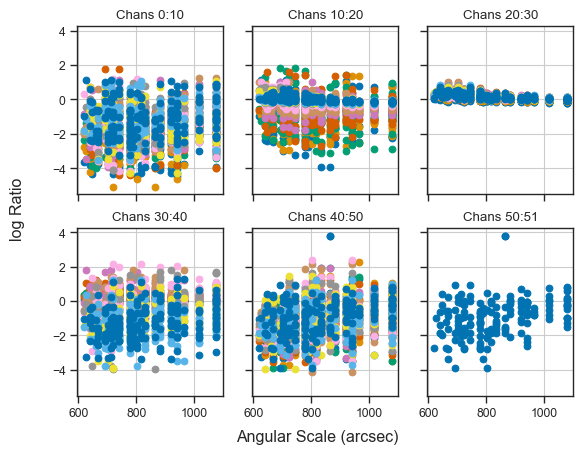

In [185]:
bins = np.linspace(-4, 4, 50)

# for chan in range(len(low_pts)):
#     _ = plt.hist(np.log(ratios[chan]), bins=bins, alpha=0.1)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

for ii, ax in enumerate(axs.ravel()):

    start = 10 * ii
    end = 10 *(ii+1) + 1
    
    for chan in range(start, end):
        try:
            ax.scatter(radii[chan], np.log(ratios[chan]),)
            # ax.scatter(radii[chan], high_pts[chan],)
        except IndexError:
            pass

    ax.set_title(f"Chans {start}:{min(end-1, len(ratios))}")

    ax.grid(True)
    
fig.supylabel(f"log Ratio")
fig.supxlabel(f"Angular Scale ({radii[0].unit})")

Optimization terminated successfully.
         Current function value: -0.215449
         Iterations: 40
         Function evaluations: 78
1.12+/-0.00


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


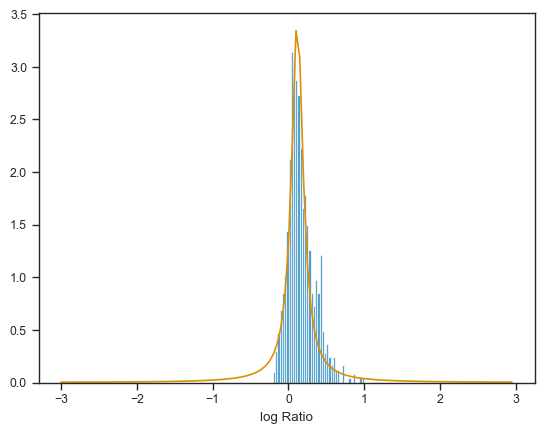

In [211]:
# Try with a subset of channels:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[20:30]),
                                      np.hstack(high_pts[20:30]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Optimization terminated successfully.
         Current function value: 1.679605
         Iterations: 49
         Function evaluations: 94
0.21+/-0.01


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


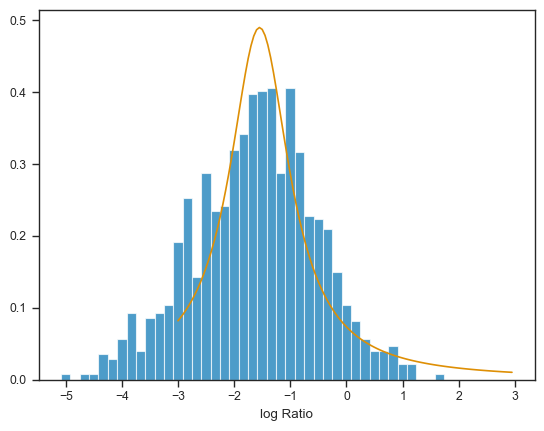

In [212]:
# Try with a subset of channels:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[0:10]),
                                      np.hstack(high_pts[0:10]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Attempt a Gaussian mixture model with 2 components

In [188]:
from sklearn.mixture import GaussianMixture

In [201]:
log_ratios = np.log(np.hstack(ratios)).reshape(-1, 1)

model = GaussianMixture(2).fit(log_ratios)

# model

In [227]:
model.covariance_type

'full'

In [231]:
sc_factor = np.exp(model.means_)
sc_factor

array([[1.10999253],
       [0.32773762]])

In [235]:
sc_err = sc_factor * np.sqrt(model.covariances_)
sc_err

array([[[0.0462555 ]],

       [[0.23730315]]])

Text(0, 0.5, '$p(x)$')

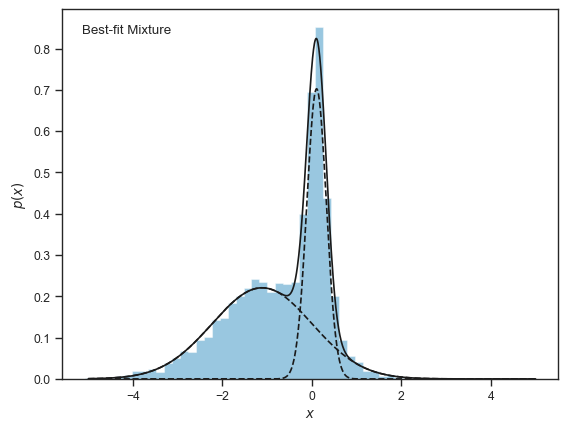

In [226]:
x = np.linspace(-5, 5, 1000)
logprob = model.score_samples(x.reshape(-1, 1))
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(log_ratios, bins=50, density=True, histtype='stepfilled', alpha=0.4)

ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


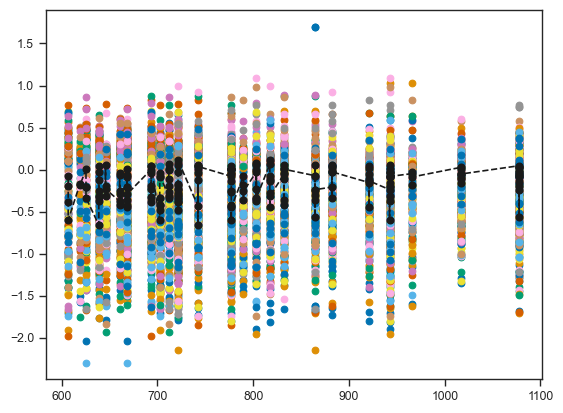

In [134]:
for chan in range(len(radii)):
    plt.scatter(radii[chan], np.log10(ratios[chan]))
    # plt.scatter(radii[chan], ratios[chan])
    
# Plot a median per angular scale
# plt.plot(radii[0], np.log10(np.median(np.vstack(ratios), axis=0)), 'k--')
plt.plot(radii[0][np.argsort(radii[0])], np.log10(np.median(np.vstack(ratios), axis=0)[np.argsort(radii[0])]), 'ko--')
# print(np.vstack(ratios).shape, radii[0].shape)


In [75]:
vla_sum = vla_cube.sum(axis=(1,2))
gbt_sum = gbt_reproj.sum(axis=(1,2))

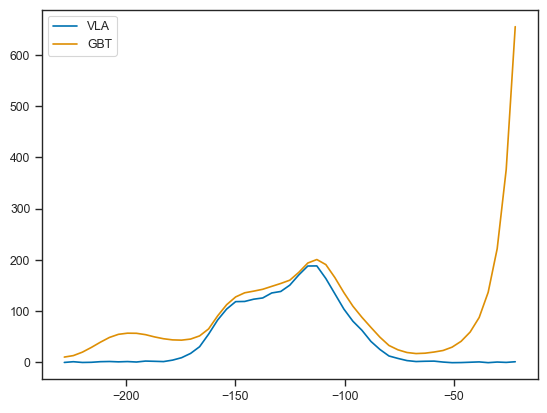

In [78]:
plt.plot(gbt_cube_specinterp.spectral_axis.value, vla_sum, label='VLA')
plt.plot(gbt_cube_specinterp.spectral_axis.value, gbt_sum / beam_ratio, label='GBT')

plt.legend()

In [79]:
from uvcombine import feather_compare

In [135]:
plane_hi = vla_cube[20]
plane_lo = gbt_reproj[20]

lowresfwhm = gbt_cube.beam.major
# lowresfwhm = 9.1 * u.arcmin


# out = feather_compare(plane_hi.to(u.K, freq=hi_freq).hdu,
#                           plane_lo.hdu,
#                           return_samples=True, doplot=False,
#                           LAS=las, SAS=lowresfwhm,
#                           lowresfwhm=lowresfwhm,)
#                           # weights=weights)
# out = feather_compare(plane_hi.hdu,
#                       (plane_lo / beam_ratio).hdu,
#                       return_samples=True, doplot=False,
#                       LAS=las, SAS=lowresfwhm,
#                       lowresfwhm=lowresfwhm,)
#                       # weights=weights)
out = feather_compare(plane_hi.to(u.K, freq=hi_freq).hdu,
                      plane_lo.to(u.K, freq=hi_freq).hdu,
                      return_samples=True, doplot=False,
                      LAS=las, SAS=lowresfwhm,
                      lowresfwhm=lowresfwhm,)
                      # weights=weights)
radii_chan, ratios_chan, highres_pts_chan, lowres_pts_chan = out

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


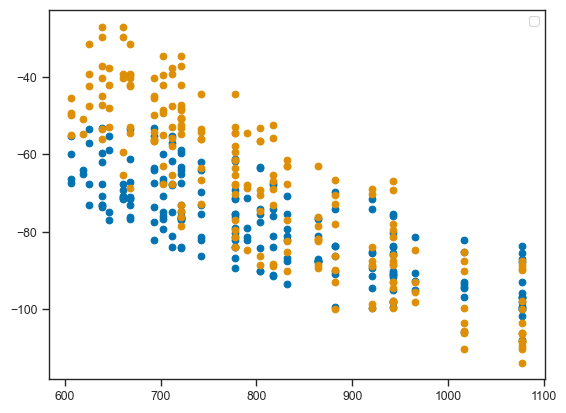

In [161]:
# plt.scatter(radii_chan, ratios_chan)
# plt.scatter(radii[20], ratios[20] - ratios_chan)
plt.scatter(radii[20], high_pts[20] - highres_pts_chan)
plt.scatter(radii[20], low_pts[20] - lowres_pts_chan)


# print(radii[20].shape, low_pts[20].shape)

# plt.scatter(radii[20], low_pts[20], label='Cube compare')
# plt.scatter(radii[20], lowres_pts_chan, label='Chan compare')
plt.legend()

Text(0, 0.5, 'Flux in overlap (K)')

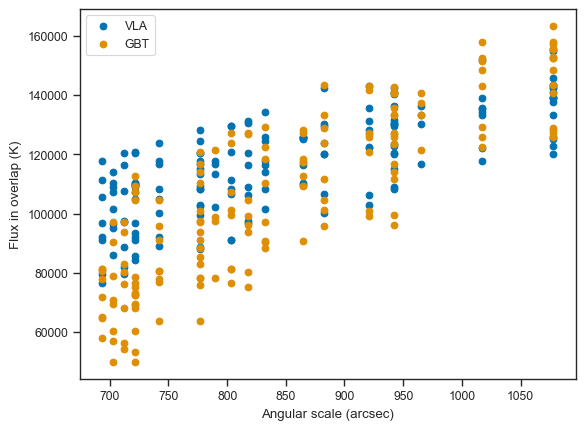

In [111]:
plt.scatter(radii, highres_pts, label='VLA')
plt.scatter(radii, lowres_pts, label='GBT')

plt.legend()

plt.xlabel(f"Angular scale ({radii.unit})")
plt.ylabel(f"Flux in overlap ({highres_pts.unit})")

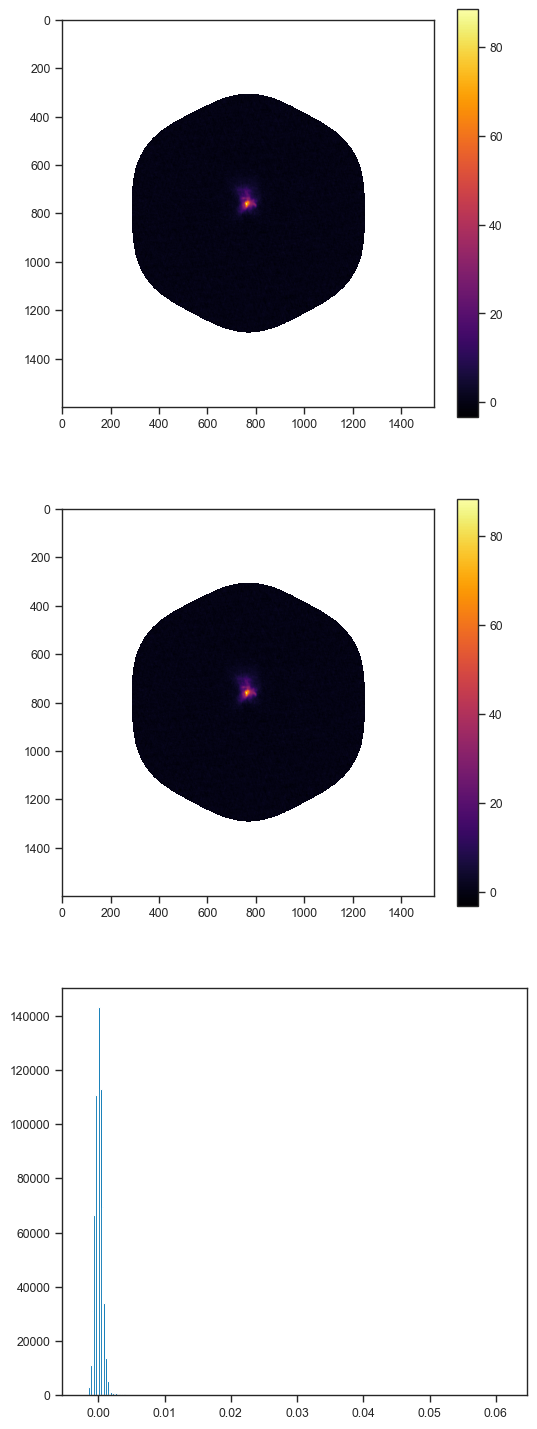

In [152]:
plt.figure(figsize=(6, 18))

plt.subplot(311)
plt.imshow(plane_hi.to(u.K, freq=hi_freq).value, cmap='inferno')
plt.colorbar()

plt.subplot(312)
plt.imshow(vla_cube.to(u.K)[20].value, cmap='inferno')
plt.colorbar()

plt.subplot(313)
# plt.imshow((plane_hi.to(u.K, freq=hi_freq).value - vla_cube.to(u.K)[20].value) / vla_cube.to(u.K)[20].value, cmap='coolwarm')
# diffs = (plane_hi.to(u.K, freq=hi_freq).value - vla_cube.to(u.K)[20].value) / vla_cube.to(u.K)[20].value
diffs = (plane_hi.to(u.K, freq=hi_freq).value - vla_cube.to(u.K)[20].value)
diffs = diffs[np.isfinite(diffs)]
_ = plt.hist(diffs, bins=250)
# plt.colorbar()

## Galactic to ICRS reprojection test:


In [7]:
vla_cube = SpectralCube.read(vla_data_path / "ngc6822_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "N6822_GBT.FITS")
# gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))


In [8]:
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

In [34]:
gbt_cube_specinterp = gbt_cube_specinterp.to(u.Jy / u.beam)

In [35]:
vla_slice = vla_cube[25]

In [36]:
gbt_slice = gbt_cube_specinterp[25]

In [37]:
from reproject import reproject_adaptive, reproject_interp

In [54]:
from astropy.wcs.utils import proj_plane_pixel_area

In [56]:
proj_plane_pixel_area(gbt_slice.wcs) / proj_plane_pixel_area(vla_slice.wcs)


7056.0000596745085

In [59]:
gbt_reproj, footprint = reproject_adaptive(gbt_slice.hdu, vla_slice.header, conserve_flux=True)
gbt_reproj *= proj_plane_pixel_area(gbt_slice.wcs) / proj_plane_pixel_area(vla_slice.wcs)

gbt_reproj_nocon, footprint = reproject_adaptive(gbt_slice.hdu, vla_slice.header, conserve_flux=False)

gbt_reproj_interp, footprint = reproject_interp(gbt_slice.hdu, vla_slice.header)

# gbt_reproj_interp2, footprint = reproject_interp(gbt_slice.hdu, vla_slice.header, order='biquadratic')

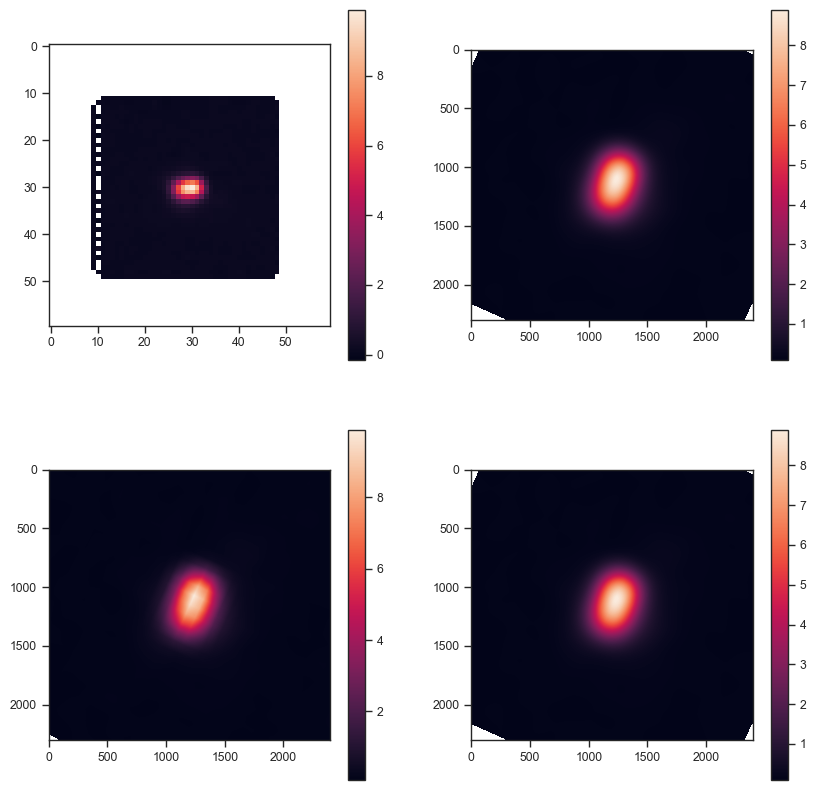

In [60]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(gbt_slice.value)
plt.colorbar()

plt.subplot(222)
plt.imshow(gbt_reproj)
plt.colorbar()

plt.subplot(223)
plt.imshow(gbt_reproj_interp)
plt.colorbar()

plt.subplot(224)
plt.imshow(gbt_reproj_nocon)
plt.colorbar()

In [61]:
np.nansum(gbt_slice)

<Slice 407.80732485 Jy / beam>

In [62]:
np.nansum(gbt_reproj)

2237539.2997549465

In [63]:
np.nansum(gbt_reproj_nocon)

2237483.9121961803

In [64]:
np.nansum(gbt_reproj_interp)

2240621.827464073

In [65]:
np.nanmax(gbt_slice)

<Slice 9.89191606 Jy / beam>

In [66]:
np.nanmax(gbt_reproj)

8.890065918025641

In [67]:
np.nanmax(gbt_reproj_interp)

9.882068246626453

## IC10: Galactic to ICRS reproject impact on the scale factor

In [79]:
def scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=False):

    stacked_ratios = np.hstack(ratios)
    stacked_ratios = stacked_ratios[np.isfinite(stacked_ratios)]
    log_ratios = np.log(stacked_ratios).reshape(-1, 1)

    model = GaussianMixture(ncomp).fit(log_ratios)
    
    sc_factor = np.exp(model.means_)
    sc_err = sc_factor * np.sqrt(np.diagonal(model.covariances_))
    
    sc_factor = sc_factor.squeeze()
    sc_err = sc_err.squeeze()
    
    if show_plot:
        x = np.linspace(-5, 5, 1000)
        logprob = model.score_samples(x.reshape(-1, 1))
        responsibilities = model.predict_proba(x.reshape(-1, 1))
        pdf = np.exp(logprob)
        pdf_individual = responsibilities * pdf[:, np.newaxis]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        _ = ax.hist(log_ratios, bins=50, density=True, histtype='stepfilled', alpha=0.4)

        ax.plot(x, pdf, '-k')
        ax.plot(x, pdf_individual, '--k')
        ax.text(0.04, 0.96, "Best-fit Mixture",
                ha='left', va='top', transform=ax.transAxes)

        ax.set_xlabel('log Ratio')
        ax.set_ylabel('PDF')

    
    return sc_factor, sc_err, model


In [71]:
vla_cube = SpectralCube.read(vla_data_path / "ic10_C+D_hilores.fits")
vla_cube.allow_huge_operations = True

gbt_cube = SpectralCube.read(sd_data_path / "ic10_comb_gal.fits")
gbt_cube = gbt_cube.with_beam(Beam(8.7*u.arcmin))

In [72]:
gbt_cube = gbt_cube.with_spectral_unit(u.m / u.s, velocity_convention='radio')

fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = np.abs(np.diff(gbt_cube.spectral_axis)[0]).to(u.km / u.s)
target_resolution = np.abs(np.diff(vla_cube.spectral_axis)[0]).to(u.km / u.s)
print(current_resolution, target_resolution)

gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  current_resolution / fwhm_factor)
print(gaussian_width)
kernel = Gaussian1DKernel(gaussian_width.value)
gbt_cube_specsmooth = gbt_cube.spectral_smooth(kernel)


gbt_cube_specinterp = gbt_cube_specsmooth.spectral_interpolate(vla_cube.spectral_axis) 

1.6101500000000233 km / s 4.123524597145006 km / s
1.0012005308118344


In [75]:
output_filename = "ic10_gbt_matched_adaptivetest_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='adaptive')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ic10_gbt_matched_adaptivetest_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [76]:
output_filename_interp = "ic10_gbt_matched_interptest_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename_interp).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename_interp,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='interp')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ic10_gbt_matched_interptest_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [80]:
hi_freq = 1.42040575 * u.GHz
las = (hi_freq.to(u.cm, u.spectral()) / (40 * u.m)).to(u.arcsec, u.dimensionless_angles())

In [77]:
gbt_reproj = SpectralCube.read(sd_data_path / output_filename)
gbt_reproj.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj = gbt_reproj.with_mask(np.isfinite(vla_cube))

In [81]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


2.86+/-1.55
3.50+/-1.89


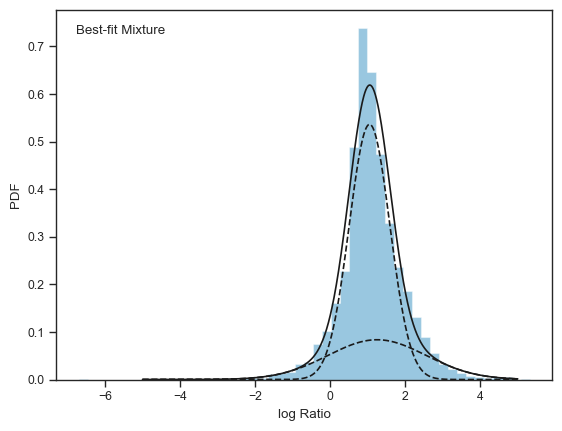

In [82]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=True)

print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

In [83]:
gbt_reproj_interp = SpectralCube.read(sd_data_path / output_filename_interp)
gbt_reproj_interp.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj_interp = gbt_reproj_interp.with_mask(np.isfinite(vla_cube))

In [84]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj_interp.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


1.90+/-2.41
1.44+/-1.83


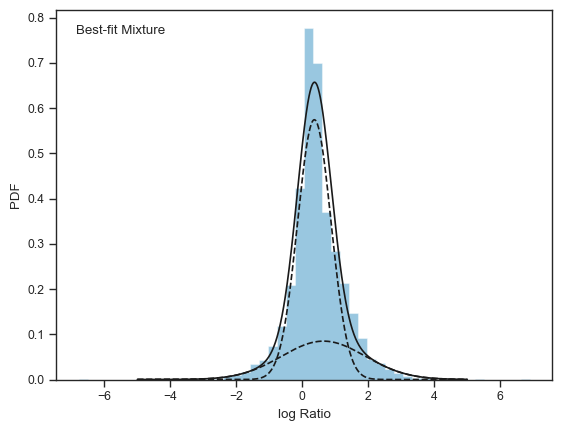

In [85]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=True)

print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

In [86]:
gbt_cube = gbt_cube.with_spectral_unit(u.km / u.s, velocity_convention='radio')
gbt_cube_specinterp = gbt_cube.spectral_interpolate(vla_cube.spectral_axis) 

In [88]:
output_filename_interp = "ic10_gbt_matched_interptest_nospecsmooth_to_C+D_hilores.fits"

try:
    (sd_data_path / output_filename_interp).unlink()
except FileNotFoundError:
    pass

reproject_cube(gbt_cube_specinterp.hdu, vla_cube.hdu,
               output_filename_interp,
               output_folder=sd_data_path,
               reproject_type='spatial',
               reproject_alg='interp')

INFO: Creating new FITS file. [cube_analysis.reprojection]
/Users/ekoch/storage/LGLBS/feathering_tests/ic10_gbt_matched_interptest_nospecsmooth_to_C+D_hilores.fits
INFO: Reprojecting and writing. [cube_analysis.reprojection]


In [89]:
gbt_reproj_interp = SpectralCube.read(sd_data_path / output_filename_interp)
gbt_reproj_interp.allow_huge_operations = True

# Multiply by the pb cut-off
gbt_reproj_interp = gbt_reproj_interp.with_mask(np.isfinite(vla_cube))

In [90]:
radii, ratios, high_pts, low_pts, chan_out = \
            feather_compare_cube(vla_cube.to(u.K),
                                 gbt_reproj_interp.to(u.K),
                                 las,
                                 lowresfwhm=None,
                                 num_cores=1,
                                 chunk=250,
                                 verbose=True,
                                 # weights=weight,
                                 relax_spectral_check=False,
                                 spec_check_kwargs={'rtol': 0.01})

INFO: On chunk 1 of 1 [cube_analysis.feather_cubes]


1.32+/-1.69
1.32+/-1.69


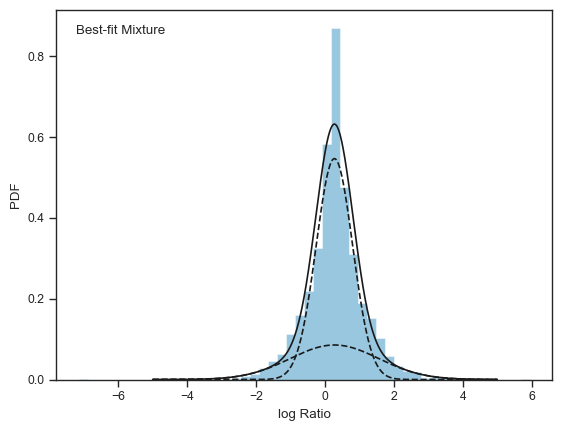

In [91]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=2, show_plot=True)

print(f"{sc_factor[0]:.2f}+/-{sc_err[0]:.2f}")
print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

1.32+/-1.07


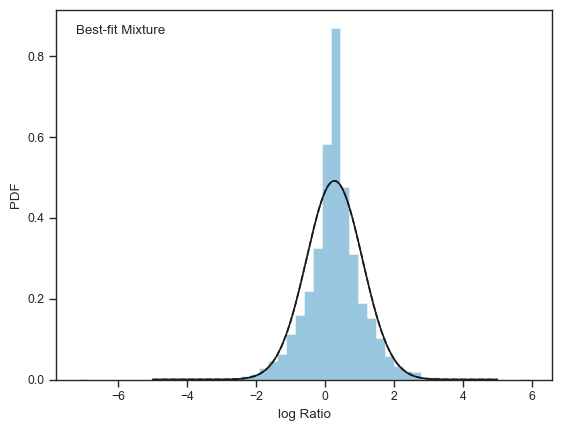

In [93]:
sc_factor, sc_err, model = scalefactor_from_mixturemodel(ratios, ncomp=1, show_plot=True)

print(f"{sc_factor:.2f}+/-{sc_err:.2f}")
# print(f"{sc_factor[1]:.2f}+/-{sc_err[1]:.2f}")

Optimization terminated successfully.
         Current function value: 1.219929
         Iterations: 42
         Function evaluations: 81
1.32+/-0.01


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


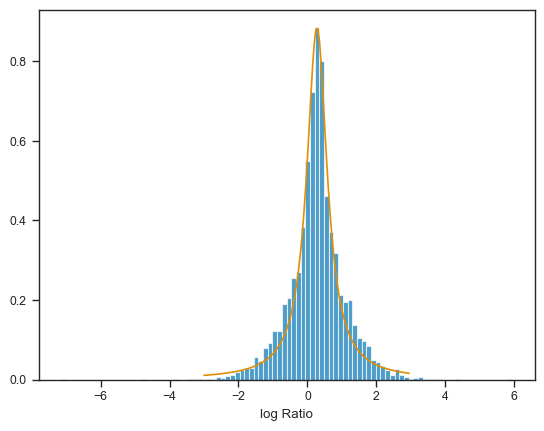

In [94]:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts),
                                      np.hstack(high_pts),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")

Optimization terminated successfully.
         Current function value: 0.960283
         Iterations: 44
         Function evaluations: 88
1.37+/-0.01


/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/ekoch/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


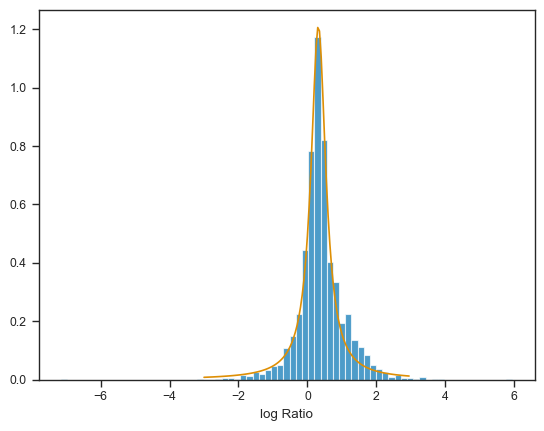

In [96]:
sc_factor, sc_err = find_scale_factor(np.hstack(low_pts[10:40]),
                                      np.hstack(high_pts[10:40]),
                                      method='distrib',
                                      verbose=True)
print(f"{sc_factor:.2f}+/-{sc_err:.2f}")